# Part II: PathMatch
***

Student ID: A0248839J  
Name: Dahyun Kim

## 0. Instruction 
* In this part, you will implement a basic version of PatchMatch (which can be used to speed-up texture synthesis) to find similar patches between two images.

  
* You are required to find for each patch in image A, a close match in image B. This close match is not exact but approximated by the PatchMatch algorithm. Patches are defined around each pixel in image A and B.

    1.  For every patch in image A, assign corresponding patch in image B arbitrarily (a random guess), and store the offsets (u, v) and patch distance D in a 3-channel array. You may use SSD of the color difference to compute D. Then, propagate the offsets in scan order from left to right, top to bottom in odd iteration, and from right to left, bottom to top in even iteration. Replace a patch’s offset with its neighbor’s if the new offset gives smaller D. For our task, it should suffice to iterate 2 to 5 times. The random search step is optional. You may refer to Sec.3.3.2 in the PatchMatch paper to implement this step if you want to improve the results.
    2. Visualize the x and y coordinates of the patch correspondence field (plot them as images). Use the pixel color given by (x, y) in image B to reconstruct image A.
    3. Show at least 3 different results
    4. Discuss your findings through the experiment, particularly: how the neighborhood size affects the synthesis results and speed? What kind of data works best/worst?


## 1. Import libraries

In [2]:
# Import lib
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import timeit

## 2. Function `get_SSD`
* `get_SSD` calculates the SSD of two patches.

In [3]:
# Caculates the SSD of two patches
def get_SSD(patch_a, patch_b):
    
    dis = patch_a - patch_b
    sq_dis = dis*dis
    ssd = np.sum(sq_dis)
    
    return ssd

## 3. Function `initialize`
* `initialize` assign corresponding patch in image B arbitraily for every patch in image A and store the offsets and patch distance D.

In [4]:
# Assign corresponding patch in image B arbitrarily for every patch in image A and store the offsets and patch distance D.
def initialize(img_array_a, img_array_b, window_size):
    print('initializing...')
    x_shape_a, y_shape_a, dima = img_array_a.shape
    x_shape_b, y_shape_b, dimb = img_array_b.shape
    
    #offset (u,v)
    #{u,v  ...  
    #      ...
    #      ...  u+d-1, v+d-1}
    
    d = window_size
    assign = np.zeros((x_shape_a-d+1, y_shape_a-d+1,3))
    
    # assign offset (u,v) in b to patch (x,y) in a
    for x in range(0,x_shape_a-(d-1)):
        for y in range(0,y_shape_a-(d-1)):
            rand_u = random.randint(0, (x_shape_b-1)-(d-1))
            rand_v = random.randint(0,(y_shape_b-1)-(d-1))
            
            patch_a = img_array_a[x:x+d-1, y:y+d-1]
            patch_b = img_array_b[rand_u:rand_u+d-1, rand_v:rand_v+d-1]
            ssd = get_SSD(patch_a, patch_b)
            
            append = [rand_u, rand_v, ssd]
            append = np.array(append)
            #print(append)
            
            assign[x,y] = append
            
    return assign # 3 Channel array with (u, v, ssd) dim= x*y*3
    

## 4. Function `propagate`
* `propagate` propagates the offsets.

In [5]:
# Improve assign using the know offsets of left, right, up, down assuming that the patch offsets are likely to be the same.
def propagate(assign, iteration):
    x_assign, y_assign, dim = assign.shape
    
    for i in range(0,iteration):
        print('iter: ',i)
        if i%2 == 1: # if odd iteration
            for x in range(0,x_assign):
                for y in range(0, y_assign):
                    if x+1 < x_assign and y+1 < y_assign:
                        #print('odd')
                        u = assign[x,y,0]
                        v = assign[x,y,1]

                        ssd_right = assign[x,y+1,2]
                        ssd_down = assign[x+1,y,2]
                        ssd = assign[x,y,2]
                        min_ssd = min(ssd_right, ssd_down, ssd)

                        if min_ssd == ssd_right:
                            assign[x,y,0] = assign[x,y+1,0] #u
                            assign[x,y,1] = assign[x,y+1,1] #v

                        elif min_ssd == ssd_down:
                            assign[x,y,0] = assign[x+1,y,0] #u
                            assign[x,y,1] = assign[x+1,y,1] #v
                        else:
                            pass
                    
        if i%2 == 0: # if even iteration
            for x in range(0,x_assign):
                for y in range(0, y_assign):
                    if x-1 >= 0 and y-1 >= 0 :
                        #print('even')
                        u = assign[x,y,0]
                        v = assign[x,y,1]

                        ssd_left = assign[x,y-1,2]
                        ssd_up = assign[x-1,y,2]
                        ssd = assign[x,y,2]
                        min_ssd = min(ssd_left, ssd_up, ssd)

                        if min_ssd == ssd_left:
                            assign[x,y,0] = assign[x,y-1,0] #u
                            assign[x,y,1] = assign[x,y-1,1] #v
                        elif min_ssd == ssd_up:
                            assign[x,y,0] = assign[x-1,y,0] #u
                            assign[x,y,1] = assign[x-1,y,1] #v
                        else:
                            pass
    return assign



## 5. Function `reconstruct`
* `reconstruct` reconstruct image A using the pixel color given in image B.

In [6]:
def reconstruct(img_array_a, img_array_b, window_size, assign):
    print('reconstructing...')
    x_shape_a, y_shape_a, dima = img_array_a.shape
    x_shape_b, y_shape_b, dimb = img_array_b.shape
    d = window_size
    
    re_img_array_a = np.zeros((x_shape_a, y_shape_a,3))
    for x in range(0,x_shape_a-(d-1)):
        for y in range(0,y_shape_a-(d-1)):
            u = int(assign[x,y,0])
            v = int(assign[x,y,1])
            
            #patch_a = img_array_a[x:x+d-1, y:y+d-1]
            patch_b = img_array_b[u:u+d-1, v:v+d-1]
            
            re_img_array_a[x:x+d-1, y:y+d-1] = patch_b
            
    return re_img_array_a

## 6. Main Function

* load Image a and b, then show image a.

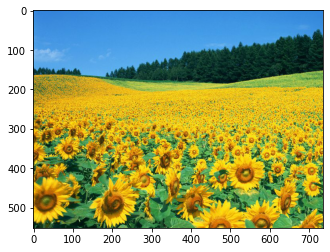

In [7]:
path1 = "pic2-1.jpg"
path2 = "pic2-2.jpg"

img_a = Image.open(path1)
img_b = Image.open(path2)

img_array_a = np.asarray(img_a, dtype="int32")
img_array_b = np.asarray(img_b, dtype="int32")

plt.imshow(img_array_a)

* Show image b

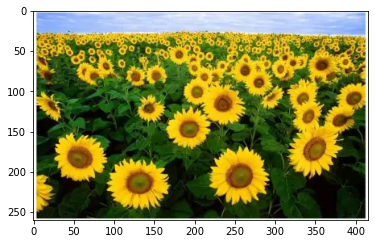

In [8]:
plt.imshow(img_array_b)

* Reconstruct image a from image b.

initializing...
iter:  0
iter:  1
iter:  2
iter:  3
iter:  4
reconstructing...


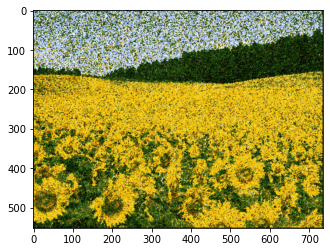

In [9]:
try:
    window_size = 3
    iteration = 5

    assign = initialize(img_array_a, img_array_b, window_size)
    assign = propagate(assign,iteration)
    new_img_array = reconstruct(img_array_a, img_array_b, window_size, assign)
    plt.imshow(new_img_array.astype('uint8'))
       
except Exception as e:
    print('Error: ', e)

## 7. Other results

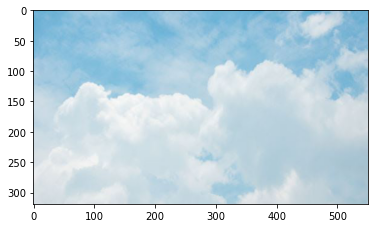

In [10]:
path1 = "pic2-3.jpg"
path2 = "pic2-4.jpg"

img_a = Image.open(path1)
img_b = Image.open(path2)

img_array_a = np.asarray(img_a, dtype="int32")
img_array_b = np.asarray(img_b, dtype="int32")

plt.imshow(img_array_a)

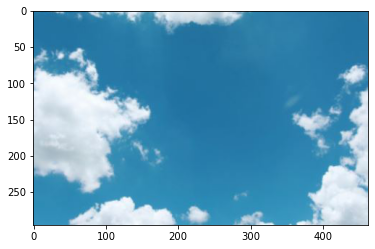

In [11]:
plt.imshow(img_array_b)

initializing...
iter:  0
iter:  1
iter:  2
iter:  3
iter:  4
reconstructing...


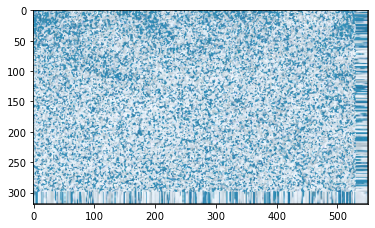

In [13]:
try:
    window_size = 20
    iteration = 5

    assign = initialize(img_array_a, img_array_b, window_size)
    assign = propagate(assign,iteration)
    new_img_array = reconstruct(img_array_a, img_array_b, window_size, assign)

    plt.imshow(new_img_array.astype('uint8'))
except Exception as e:
    print(e)

## 8. Discuss
* Unlike part 1, increasing the neighborhood size decreases the speed of synthesis. This is because of the initializing process, where the patch distances are stored in a array. If the neighborhood size is increased, it takes more time to calculate the distances between patches. 
* Although the results above is not very successful, you can still see that the result of the similar coloring works better.